In [166]:
#approx run time: 18 minutes
#check what version of python you're using - I think mine (AER) is 3.8.5
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.13


In [167]:
#image plotting in python
def implot(data, w, wcscond, vmax_p, vmin_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =vmin_p, vmax=vmax_p)
    plt.colorbar()
    plt.xlabel('RA')
    plt.ylabel('Dec')

    
# #finding the path to every fits images in a directory - needs more work, ignore for now
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data usually from some FITS format image
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. If you want to name it something else, it will get string split at the / character, and the func only takes the last element of that splitting. So you can do something like ' /...'
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_'). I usually append some extra info to the filename, though that can be flexible
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



In [168]:
#reading in file paths and data, change as you like
# path_data = 'fitting_withOI_rms/*cutout*656shifted*'
path_data = '../inanna_runs/cutout_fluxcutoff/*.fits'
files_data = [i.replace('\\', '/') for i in glob.glob(path_data+'*')[-3:]] #change this to just pick out just the nir images (126, 128, 164)
hdu_list = [fits.open(i) for i in files_data] 

print(path_data, files_data)

#grabbing data and headers
count = 0 #I always have count here because sometimes images are formatted inconsistently or indexed differently
hdu_data_list = []
hdu_header_list = []

for hdu_data in hdu_list:
    #reading in data for general use and header for wcs
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)

    count += 1
    
w = WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't since they're aligned
wcs_header = w.to_header()

#removing nans from the data, repacking it for convenient use 
f2 = np.nan_to_num(hdu_data_list[0])
f3 = np.nan_to_num(hdu_data_list[1])
f4 = np.nan_to_num(hdu_data_list[2])
nir_flux = np.array([f2, f3, f4])

#list of wavelengths for each filter being used ... not sure how to code this automatically
lam_val = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS
lam_arr = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS
# lam_arr = np.array([lam*np.ones((nir_flux[0].shape[0], nir_flux[0].shape[1])) for lam in lam_val], dtype='uint8')

../inanna_runs/cutout_fluxcutoff/*.fits ['../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_26_mic.fits', '../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_28_mic.fits', '../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_64_mic.fits']


In [169]:
#setting some initial values for fitting extinction and continuum
R_Fe = 2.6
T_list = np.linspace(100, 3000, 300) #example list of temperatures
Av_list = [0, 5, 10, 15] # np.linspace(1, 20, 10)
print(T_list)

f2 = 7e-17
f3 = 2.5e-17
f4 = 5e-17
pix_flux = [f2, f3, f4]

[ 100.          109.69899666  119.39799331  129.09698997  138.79598662
  148.49498328  158.19397993  167.89297659  177.59197324  187.2909699
  196.98996656  206.68896321  216.38795987  226.08695652  235.78595318
  245.48494983  255.18394649  264.88294314  274.5819398   284.28093645
  293.97993311  303.67892977  313.37792642  323.07692308  332.77591973
  342.47491639  352.17391304  361.8729097   371.57190635  381.27090301
  390.96989967  400.66889632  410.36789298  420.06688963  429.76588629
  439.46488294  449.1638796   458.86287625  468.56187291  478.26086957
  487.95986622  497.65886288  507.35785953  517.05685619  526.75585284
  536.4548495   546.15384615  555.85284281  565.55183946  575.25083612
  584.94983278  594.64882943  604.34782609  614.04682274  623.7458194
  633.44481605  643.14381271  652.84280936  662.54180602  672.24080268
  681.93979933  691.63879599  701.33779264  711.0367893   720.73578595
  730.43478261  740.13377926  749.83277592  759.53177258  769.23076923
  778.92

In [170]:
#constants and function for planck's law
h = 6.626e-27 #CGS units, ergs*sec
c = 2.998e10 #CGS units, cm/s
k_B = 1.38e-16 #CGS, ergs/K

def B_lam(input_arr, temp=2000):
    lam = input_arr
    return 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)

# functions below to model Av(T), scale factor for blackbody emission, intensity(1.64 mic), and intensity(1.26 mic)
y_arr = [0.47245, 0.77307, 0.78015, 0.85001] #this is used in general for our equations

#scale for blackbody continuum
def C_func(pix_flux, param_guesses):
    f2 = pix_flux[0]
    f4 = pix_flux[2]
    T, Av = param_guesses
    
    C = (R_Fe*f4/y_arr[3]**Av - f2/y_arr[1]**Av ) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T))
    return C

#[FeII] line intensityintensity at 1.64 mic
def fFe_func(pix_flux, param_guesses):
    f2 = pix_flux[0]
    f4 = pix_flux[2]
    T, Av = param_guesses

    fFe = f4/y_arr[3]**Av - C_func(pix_flux,param_guesses) * B_lam(lam_arr[3], T)
    return fFe

#HI line intensityintensity at 1.28 mic
def fH_func(pix_flux, param_guesses):
    f3 = pix_flux[1]
    T, Av = param_guesses
    
    fH = f3/y_arr[2]**Av - C_func(pix_flux, param_guesses) * B_lam(lam_arr[2], T)
    return fH




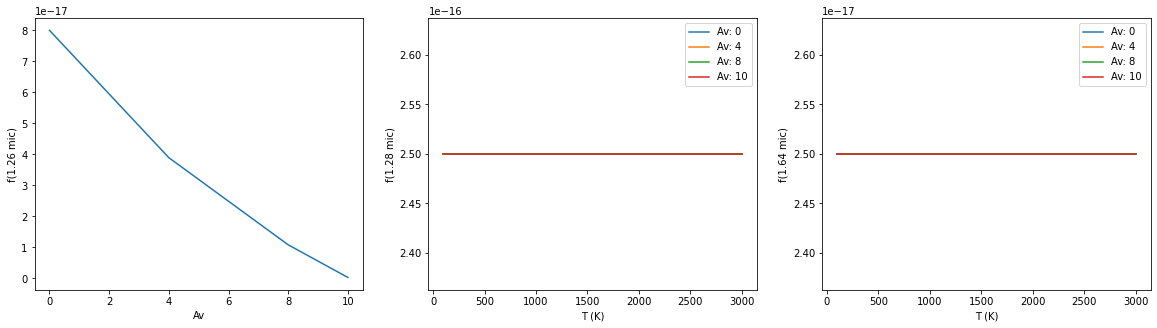

In [171]:
#checking behavior of T and Av; for parameter spaces
#changes confirmed here need to be changed in: Av_func, scatt_func, and latter half of next cell (where Av(T) is computed post-solving)

fig, ax_list = plt.subplots(ncols=3, figsize=(20,5))

#trying different parameters
Av_list = [0, 4, 8, 10]
f2 = 5e-17
f3 = f2 * 5
f4 = f2 * 0.5
pix_flux = [f2, f3, f4]

#computing example Avs and then plotting
for Av in Av_list: 
    C = (R_Fe*f4/y_arr[3]**Av - f2/y_arr[1]**Av ) / (B_lam(lam_arr[1], T_list) - R_Fe*B_lam(lam_arr[3], T_list))
    fFe = f4/y_arr[3]**Av - C * B_lam(lam_arr[3], T_list)
    fH = f3/y_arr[2]**Av - C* B_lam(lam_arr[2], T_list)
    
    theory_intens = np.array([(R_Fe * fFe + C*B_lam(lam_arr[1], T_list)) * y_arr[1]**Av,
                            (fH + C*B_lam(lam_arr[2], T_list)) * y_arr[2]**Av,
                            (fFe + C*B_lam(lam_arr[3], T_list)) * y_arr[3]**Av ])

    ax_list[1].plot(T_list, theory_intens[1], label='Av: '+str(Av))
    ax_list[2].plot(T_list, theory_intens[2], label='Av: '+str(Av))

#1.26 is independent of T, but depends on Av!
T_126 = 5000
C = (R_Fe*f4/y_arr[3]**np.array(Av_list) - f2/y_arr[1]**np.array(Av_list) ) / (B_lam(lam_arr[1], T_126) - R_Fe*B_lam(lam_arr[3], T_126))
fFe = f4/y_arr[3]**np.array(Av_list) - C * B_lam(lam_arr[3], T_126)
ax_list[0].plot(Av_list, (R_Fe * fFe + C*B_lam(lam_arr[1], T_126)) * y_arr[1]**np.array(Av_list))

#1.28 and 1.64 are independent of Av?

ax_list[0].set_xlabel('Av')
ax_list[0].set_ylabel('f(1.26 mic)')

ax_list[1].set_ylabel('f(1.28 mic)')
ax_list[1].set_xlabel('T (K)')
ax_list[1].legend(loc='best')

ax_list[2].set_ylabel('f(1.64 mic)')
ax_list[2].set_xlabel('T (K)')
ax_list[2].legend(loc='best')

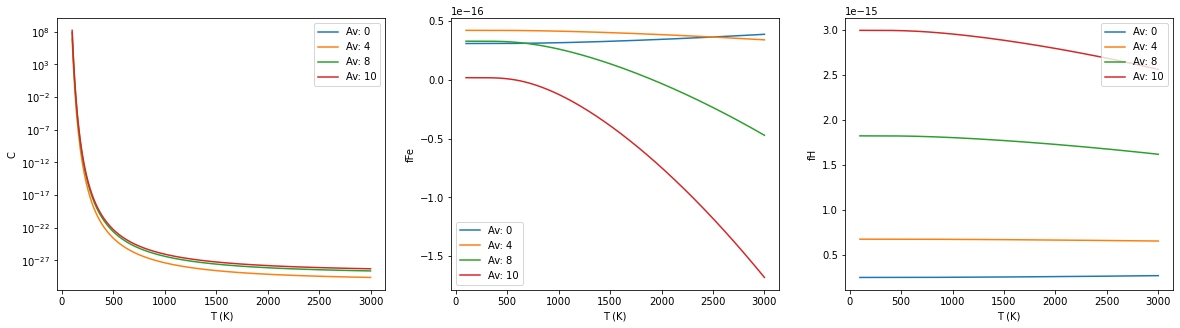

In [172]:
#checking behavior of T and Av; but for the output of intensities
#changes confirmed here need to be changed in: Av_func, scatt_func, and latter half of next cell (where Av(T) is computed post-solving)

fig, ax_list = plt.subplots(ncols=3, figsize=(20,5))

#trying different parameters
Av_list = [0, 4, 8, 10]
f2 = 5e-17
f3 = f2 * 5
f4 = f2 * 0.5
pix_flux = [f2, f3, f4]

#computing example Avs and then plotting
for Av in Av_list: 
    input_guess = [T_list, Av]
    ax_list[0].plot(T_list, C_func(pix_flux, input_guess), label='Av: '+str(Av))
    ax_list[1].plot(T_list, fFe_func(pix_flux, input_guess), label='Av: '+str(Av))
    ax_list[2].plot(T_list, fH_func(pix_flux, input_guess), label='Av: '+str(Av))

ax_list[0].set_ylabel('C')
ax_list[0].set_yscale('log')
ax_list[1].set_ylabel('fFe')
ax_list[2].set_ylabel('fH')

for ax in ax_list:
    ax.set_xlabel('T (K)')
    ax.legend(loc='best')

In [195]:
#displaying Av if we assume continuum to be irrelevant, seems like 1.26 works well
#nir_flux is ordered as 1.26, 1.28, 1.64
Av_ignoreCont = -np.log(R_Fe * nir_flux[0] / nir_flux[2]) / np.log(y_arr[1]/y_arr[3])
file_start=''
saved = fits_saver(Av_ignoreCont, wcs_header, 'ex/A_V_ignoreCont_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)


C:\Users\arubi\AppData\Local\Temp\ipykernel_27340\1195290276.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Av_ignoreCont = -np.log(R_Fe * nir_flux[0] / nir_flux[2]) / np.log(y_arr[1]/y_arr[3])
C:\Users\arubi\AppData\Local\Temp\ipykernel_27340\1195290276.py:3: RuntimeWarning: invalid value encountered in true_divide
  Av_ignoreCont = -np.log(R_Fe * nir_flux[0] / nir_flux[2]) / np.log(y_arr[1]/y_arr[3])
C:\Users\arubi\AppData\Local\Temp\ipykernel_27340\1195290276.py:3: RuntimeWarning: divide by zero encountered in log
  Av_ignoreCont = -np.log(R_Fe * nir_flux[0] / nir_flux[2]) / np.log(y_arr[1]/y_arr[3])


In [181]:
#the general solution I use, choose your output is made to be used in a faster minimize or least squares routine
#a few examples are given (chi^2, diff, rms, etc)
def resid_func(input_arr, I1, I2, I3):   
    T, Av = input_arr
    I126, I128, I164 = I1, I2, I3
    B_lam_arr = [B_lam(lam_val[1], T), B_lam(lam_val[2], T), B_lam(lam_val[3], T)] #computing once so the calculation is not repeated
    
    C = (R_Fe*f4/y_arr[3]**Av - f2/y_arr[1]**Av ) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T))
    fFe = f4/y_arr[3]**Av - C * B_lam(lam_arr[3], T)
    fH = f3/y_arr[2]**Av - C* B_lam(lam_arr[2], T)
    
    #some print statements if you want to check anything
    # print(T, I126, I128, I164, B_lam_arr, Av, fFe, C, fH)
    # print(np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
    #     (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
    #     (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ]))
    
    obs_intens = np.array([I126, I128, I164]) #should be same as pix_flux as defined in loop, a line flux at each pixel...
    theory_intens = np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
                            (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
                            (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ])
#     n_obs = len(obs_intens) #if you want to test the return options
    
    return obs_intens - theory_intens
    #return np.sqrt(np.sum((obs_intens - theory_intens)**2.)) / (n_obs -1.) #technically not accurate, but it does provide different scaling 
    # return np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.)) 

#the general solution I use, choose your output is made to be used in a faster minimize or least squares routine
#a few examples are given (chi^2, diff, rms, etc)
def summed_resids(input_arr, I1, I2, I3):   
    T, Av = input_arr
    I126, I128, I164 = I1, I2, I3
    B_lam_arr = [B_lam(lam_val[1], T), B_lam(lam_val[2], T), B_lam(lam_val[3], T)] #computing once so the calculation is not repeated
    
    C = (R_Fe*f4/y_arr[3]**Av - f2/y_arr[1]**Av ) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T))
    fFe = f4/y_arr[3]**Av - C * B_lam(lam_arr[3], T)
    fH = f3/y_arr[2]**Av - C* B_lam(lam_arr[2], T)
    
    #some print statements if you want to check anything
    # print(T, I126, I128, I164, B_lam_arr, Av, fFe, C, fH)
    # print(np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
    #     (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
    #     (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ]))
    
    obs_intens = np.array([I126, I128, I164]) #should be same as pix_flux as defined in loop, a line flux at each pixel...
    theory_intens = np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
                            (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
                            (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ])
#     n_obs = len(obs_intens) #if you want to test the return options
    
    #return np.sqrt(np.sum((obs_intens - theory_intens)**2.)) / (n_obs -1.) #technically not accurate, but it does provide different scaling 
    return np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.)) 

In [190]:
from scipy.optimize import minimize #curve_fit, least_squares, leastsq

#initial guess
T_guess = 2000
Av_guess = 3.5
input_guess = [T_guess, Av_guess]

#restricting parameter space, (T, Av)
bound_lower = (0, 0)
bound_upper = (3000, 20)
bound_list = (bound_lower, bound_upper)  #[T_bound, Av_bound]
# R_Fe = 2.6
# R_Fe_list = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
R_Fe_list = [2.6] #out forbidden iron 2 line ratio

#looping through R_Fe to solve for temperatures
fit_arr = [[] for x in range(nir_flux[0].shape[0] * nir_flux[0].shape[1])]
for R_Fe in R_Fe_list:
    count = 0
    
    #looping through x-axis values
    for i in range(nir_flux[0].shape[0]):
        #looping through y-axis values
        for j in range(nir_flux[0].shape[1]):
            pix_flux = np.array([nir_flux[0][i, j], nir_flux[1][i, j], nir_flux[2][i, j]]) #intensity to be fit
            try:
    #           #now for least squares fit, I set gtol very low but it could be slightly more flexible
                #using base version of lm, unbounded only works a few times...
                # res = leastsq(resid_func, input_guess, args=(pix_flux[0], pix_flux[1], pix_flux[2]), ftol=2e-16) #, gtol=1e-40, max_nfev=500, bounds=(0,np.inf)) #other params
                # T_fit, Av_fit = res[0]
                #using lm with bounds, a more general least_squares function
                # res = least_squares(resid_func, input_guess, args=(pix_flux[0], pix_flux[1], pix_flux[2]), ftol=3e-16, bounds=((0,0), (2000,20))) #, gtol=1e-40, max_nfev=500, bounds=(0,np.inf)) #other params
                # T_fit, Av_fit = res.x[0]

                #alternative methods
                # res = c
                # urve_fit(resid_func, input_guess, args=(pix_flux[0], pix_flux[1], pix_flux[2]), ftol=3e-16, bounds=((0,0), (2000,20))) #, gtol=1e-40, max_nfev=500, bounds=(0,np.inf)) #other params
                # T_fit, Av_fit = res.x[0]
                res = minimize(summed_resids, input_guess, args=(pix_flux[0], pix_flux[1], pix_flux[2]), tol=3e-16, bounds=((350,2500), (0,18))) #, gtol=1e-40, max_nfev=500, bounds=(0,np.inf)) #other params
                T_fit, Av_fit = res.x

                fit_arr[count] = [i, j, T_fit, Av_fit]

            except Exception as e2: #in case no fit can be found, can check why here
                # print('type is:', e2.__class__.__name__) 
                print('no fit found: ', e2)
                fit_arr[count] = (i, j, np.nan, np.nan)
            count +=1


    #setting up array of equation variables for saving
    #probably faster ways of doign this, but I found this easier to test
    f_H_arr = np.zeros_like(nir_flux[0])
    f_Fe_arr = np.zeros_like(nir_flux[0])
    C_arr = np.zeros_like(nir_flux[0])
    A_V_arr = np.zeros_like(nir_flux[0])
    T_arr = np.zeros_like(nir_flux[0])
    rms_arr = np.zeros_like(nir_flux[0])

    #reorganizing data in 2d array
    for line in fit_arr:
        T = line[2]
        Av = line[3]

        #indices
        i = line[0]
        j = line[1]
        T_arr[i][j] = T
        A_V_arr[i][j] = Av

        #using indices, T to compute...
        I126, I128, I164 = np.array([nir_flux[0][i, j], nir_flux[1][i, j], nir_flux[2][i, j]]) 
        B_lam_arr = [B_lam(lam_val[1], T), B_lam(lam_val[2], T), B_lam(lam_val[3], T)]

        #below, the fit param (Av, C, fFe, fH) are calculated based on temperature, then stored in their respective _arr list        
        C = (R_Fe*I164/y_arr[3]**Av - I126/y_arr[1]**Av ) / (B_lam_arr[0]- R_Fe*B_lam_arr[2])
        C_arr[i][j] = C
        
        fFe = I164/y_arr[3]**Av - C * B_lam_arr[2]
        f_Fe_arr[i][j] = fFe
        
        fH = I128/y_arr[2]**Av - C * B_lam_arr[1]
        f_H_arr[i][j] = fH
        
        #can change this to be the quality factor you use in your fit
        theory_intens = np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av, (fH + C*B_lam_arr[1]) * y_arr[2]**Av, (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ])
    #     n_obs = len(pix_flux)
        rms = np.sqrt(np.sum((pix_flux - theory_intens)**2./(pix_flux)**2.))
        rms_arr[i][j] = rms

    #saving data files, note fits_saver outputs the files in file_start, and the function should return that path to confirm
    file_start=''
    saved = fits_saver(rms_arr, wcs_header, 'ex/rms_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(T_arr, wcs_header, 'ex/T_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(C_arr, wcs_header, 'ex/C_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(A_V_arr, wcs_header, 'ex/A_V_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(f_H_arr, wcs_header, 'ex/f_H_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(f_Fe_arr, wcs_header, 'ex/f_Fe_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)

C:\Users\arubi\AppData\Local\Temp\ipykernel_27340\3193807656.py:52: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.))
